### Ielādē pakotnes

In [1]:
# Aprēķiņāšanas pakotnes
import numpy as np
import pandas as pd
from functools import reduce
from scipy.stats import gaussian_kde

# Zīmēšanas pakotnes
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
plt.style.use('fivethirtyeight')
from matplotlib import font_manager

font_path = '/home/jlv/.local/share/fonts/BerkeleyMono-Bold.otf'
font_manager.fontManager.addfont(font_path)
font_path = '/home/jlv/.local/share/fonts/BerkeleyMono-Regular.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# Interneta pakotnes
import requests
from bs4 import BeautifulSoup

# Pakotnes valodu atpazīšanai
from polyglot.detect import Detector

### Avots 1: profesiju kalkulators
https://www.lm.gov.lv/lv/klasifikacija/profesiju-klasifikators-5<br>
CSV formātā

In [2]:
# Ielasi
df1 = pd.read_csv('profesiju-klasifikators-aktualizets-2023gada-9decembri.csv')

# Funkcija, lai atlasītu vārdus ar lieliem burtiem
def get_caps(s):
    s_return = s
    for c in ['/',',','(',')']:
        s_return = s_return.replace(c,'')
    l_return = s_return.split(' ')
    upper_count = [sum(1 for x in v if x.isupper()) for v in l_return]
    l_return = [l_return[i] for i,c in enumerate(upper_count) if c >= 2]
    # for v in l_return:
    #     assert v==v.upper(), f"Error: word '{v}' is not all caps"
    
    # Drop wierd
    for v in ['BT','OAW', 'MAG', 'MIG', 'TIG', 'MMA']:
        try:
            at = l_return.index(v)
            l_return = l_return[:at]+l_return[at+1:]
        except:
            pass
    
    if len(l_return) > 0:
        return l_return
    else:
        return s_return.split(' ')

# Deklarē vārdnīcu
profesiju_dict = {'A':[], 'E':[], 'Ē':[], 'S':[], 's':[], 'J':[]}

# Aprēķini galotnes
for row_index in df1[df1['Apraksts'].isna()].index:
    v = df1.iloc[row_index]['Nosaukums']
    k = df1.iloc[row_index]['Kods']
    profesiju_dict[get_caps(v)[-1][-1]].append(f"{k} {v}")
    
# Masīvs vizualizācija
results1 = [2,10+4,3636+3+1]

# Parādi rezultātus
for key in profesiju_dict:
    print(f"{key}: {len(profesiju_dict[key])}")

A: 10
E: 4
Ē: 2
S: 3636
s: 3
J: 1


### Avots 2: cv.lv
https://cv.lv/lv<br>
Visas vakances

In [3]:
# Deklarē masīvu
profesijas = []
algas = []

# Funkcija lai dabūtu videjo algu
def alga(a):
    a_split = a.split()
    a_numbers = []
    for s in a.split():
        if np.intersect1d(['0','1','2','3','4','5','6','7','8','9'],[c for c in s]).shape[0] > 0:
            a_numbers.append(int(float(s)))
    if len(a_numbers)==1:
        answer = a_numbers[0]
    else:
        answer = int(np.average(a_numbers))
        
    if answer < 150:
        return answer*80
    elif answer == 150:
        return 1500
    else:
        return answer

# Izej cauri sarakstam
pedeja_lapa = False
lapa,rezultati = (1,1000)
print('Lasa lapas: ', end='', flush=True)
while not pedeja_lapa:
    print(lapa, end=' ', flush=True)
    url = f"https://cv.lv/lv/search?limit={lapa*rezultati}&offset={(lapa-1)*rezultati}&isHourlySalary=false"
    raw = requests.get(url)
    decoded = raw.content.decode()
    soup = BeautifulSoup(decoded, features='html.parser')
    
    # Savieno jomas ar lapām
    raw = soup.findAll(True, {'class':[
        'jsx-3024910437 vacancy-item__title', 
        'jsx-3024910437 vacancy-item__salary-label'
    ]})
    which = 0
    count = 0
    for element in raw:
        if which == 1:
            if 'vacancy-item__salary-label' in element.attrs['class']:
                algas.append(alga(element.contents[0].strip()))
            else:
                algas.append(0)
                which  = 0 
        if which == 0:
            assert 'vacancy-item__title' in element.attrs['class']
            profesijas.append(element.contents[0].strip())
            count += 1
        which = (which + 1)%2
        
    # Nākamā lapa
    lapa += 1

    # Pārbaudi vai beigas
    if count < rezultati:
        pedeja_lapa = True

df_source = pd.DataFrame.from_dict({'p':profesijas, 'a':algas})
df_source.to_csv('profesijas.csv',mode='x',index=False)

print(f"\nVisas izlasītas\nAtrastas {len(profesijas)} vakances",flush=True)

Lasa lapas: 1 2 3 
Visas izlasītas
Atrastas 2686 vakances


In [3]:
# Funkcija lai identificētu galotnes
def galotne(p):
    galotnes = ['a','as','ā','ce','dze','e','es','ēm','ģe','i','iece','is','ja','ke','ķe','re','s','te','u']
    q = p.lower()
    
    # Remove chars
    for c in ['/','-','(',')','.','"']:
        q = q.replace(c,' ')
        
    # Remove confsing words
    for w in ['3d', 'dobelē', 'vācijā', 'jēkapbilī', 'jēkabpils', 'kfc']:
        q = q.replace(w,' ')
        
    # Fix whitspace
    q = q.strip()
    while q.count('  ') > 0:
        q = q.replace('  ',' ')
    
    if np.intersect1d(q.split(),galotnes).shape[0] > 0:
        return 'lv'
    else:
        space_count = q.count(' ')
        q = q.strip()
        
        # Viens vārds
        if space_count == 0:
            if q[-1] == 's':
                return 'lv_v'
            elif q[-1] == 'i':
                return 'lv' 
            elif q[-1] in ['e','a']:
                return 'lv_s'
            else:
                return 'cits'
                
        # Divi vārdi
        elif space_count == 1:
            if q[-1] == 's':
                return 'lv_v'
            elif q[-1] == 'i':
                return 'lv' 
            elif q[-1] in ['e','a']:
                return 'lv_s'
            else:
                return 'cits'
                
        # Cits
        else:
            return 'cits'

In [105]:
# Deklarē sarakstus
df_dict = {'p':[],'alga':[]}
df_cols = []
iznemumi_en = ['office', 'system']
iznemumi_lv = [
    'agronoms', 'analītiķis', 'asistents', 'administrators', 'administratore', 'baņķieris', 'brokeris', 'brokere',
    'direktors', 'dizaineris', 'ekonomists', 'ekspeditors', 'eksperts',
    'farmaceits', 'inventarizators', 'inženieris', 'juriskonsults', 'konstruktors', 'konsultants', 'koordinators', 
    'laborants', 'masieris', 'menedžeris', 'montieris', 'operators', 'operatore', 'optometrists',
    'pārdevējs', 'revidents', 'stjuarts', 'šuvējs', 'terapeits']

# Identificē valodas
for i in range(df_source.shape[0]):
    p,a = df_source.iloc[i]
    
    df_dict['p'].append(p)
    df_dict['alga'].append(a)
    
    if i%100 == 0:
        print(i, end=' ', flush=True)    
        
    # Zinami gadījumi, kd nepareizu valodu izvēlas
    if np.any([q in p.lower() for q in iznemumi_en]):
        df_cols.append('nonlv')

    elif np.any([q in p.lower() for q in iznemumi_lv]):
        df_cols.append(galotne(p))
    
    # Pārējie gadījumi
    else:
        try:
            valodas = Detector(p).languages
            valodas_dict = {}
            for v in valodas:
                if v.confidence > 10:
                    valodas_dict[v.name] = v.confidence
            if len(valodas_dict) > 1:
                df_cols.append('mult')
            elif 'Latvian' in valodas_dict:
                df_cols.append(galotne(p))
            else:
                df_cols('nonlv')
        except:
            df_cols.append('cits')

# Izveido tabulu
for t in np.unique(df_cols):
    df_dict[t] = ['' for _ in range(len(df_cols))]
for i,result in enumerate(df_cols):
    df_dict[result][i] = 'x'
df = pd.DataFrame.from_dict(df_dict)
df = df[['p', 'alga', 'lv', 'lv_s', 'lv_v', 'nonlv', 'mult', 'cits']]
df = df.sort_values(
    by=['lv', 'lv_s', 'lv_v', 'nonlv', 'mult', 'cits','p'],
    ascending=[False,False,False,False,False,False,True]
)

# Saglabā manuālai labošanai
df.to_csv('profesijas_galotnes.csv', mode='x', index=False)

0 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


100 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


200 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


300 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


400 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


500 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


600 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


700 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


800 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


900 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1000 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1100 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1200 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1300 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1400 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1500 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1600 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1700 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1800 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


1900 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


2000 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


2100 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


2200 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


2300 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


2400 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


2500 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


2600 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


2700 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


2800 

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.


In [3]:
# Ielasi labotos rezultātus
df2 = pd.read_csv('profesijas_galotnes.csv').fillna(0)

# Masīvs vizualizācijai
results2 = [
    np.count_nonzero(df2['lv'])+np.count_nonzero(df2['nonlv'])+np.count_nonzero(df2['mult'])+np.count_nonzero(df2['cits']),
    np.count_nonzero(df2['lv_s']),
    np.count_nonzero(df2['lv_v'])
]

### Grafiks 1: salīdzini abus

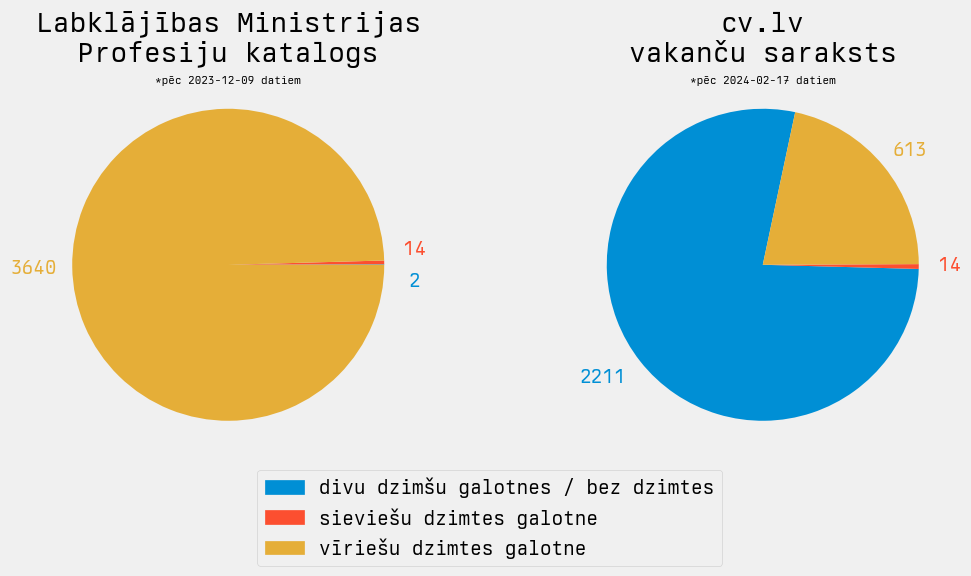

In [62]:
# Deklarē
fig,axes = plt.subplots(1,2,figsize=(10,6))

# Kreisā puse
ax = axes[0]
ax.set_title('Labklājības Ministrijas\nProfesiju katalogs')
ax.pie(results1, startangle=0)
for ang,r,d,c in zip([-5,5,181],results1,[1.2,1.2,1.25],['C0','C1','C2']):
    x = np.cos(ang*np.pi/180)*d
    y = np.sin(ang*np.pi/180)*d
    ax.text(x,y,str(r), va='center', ha='center', color=c)
ax.text(0,1.15,'*pēc 2023-12-09 datiem', ha='center', va='bottom', fontsize=8)

# Labā puse
ax = axes[1]
ax.set_title('cv.lv\nvakanču saraksts')
ax.pie(results2, startangle=78)
for ang,r,d,c in zip([215,0,38],results2,[1.25,1.2,1.2],['C0','C1','C2']):
    x = np.cos(ang*np.pi/180)*d
    y = np.sin(ang*np.pi/180)*d
    ax.text(x,y,str(r), va='center', ha='center', color=c)
ax.text(0,1.15,'*pēc 2024-02-17 datiem', ha='center', va='bottom', fontsize=8)

# Stils
handles = [
    Patch(color='C0', label='divu dzimšu galotnes / bez dzimtes'), 
    Patch(color='C1', label='sieviešu dzimtes galotne'), 
    Patch(color='C2', label='vīriešu dzimtes galotne')
]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(-.2,0))

# Saglabā un parādi
plt.subplots_adjust(right=1,left=0.02, bottom=0.2, top=.85)
plt.savefig('new1.png', dpi=300)
plt.show()

### Grafiks 2: Valodas un piemēri

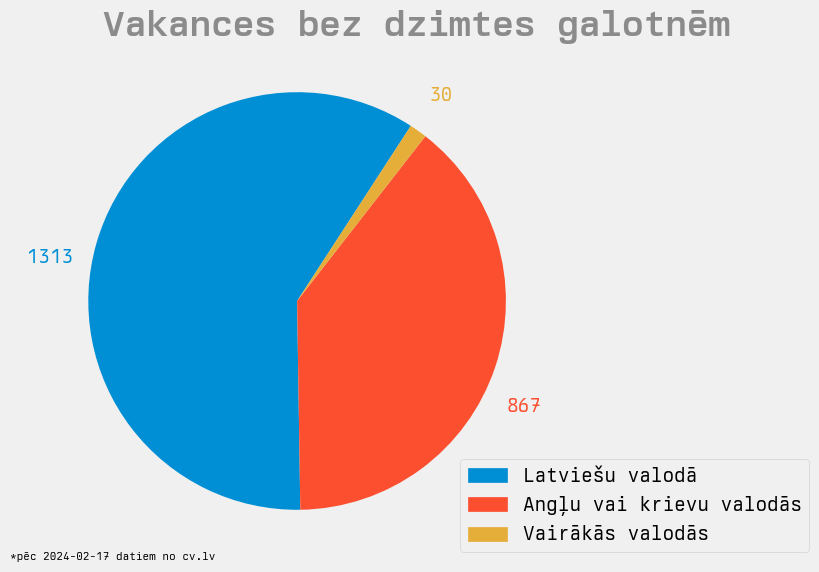

In [63]:
# Deklarē
fig = plt.figure(figsize=(8.5,6))
ax = plt.gca()

# Zīmē
data = [
    df2[df2['lv']!=0].shape[0],
    df2[df2['nonlv']!=0].shape[0],
    df2[df2['mult']!=0].shape[0]
]
ax.pie(data, startangle=57)
for ang,r,d,c in zip([170,-25,55],data,[1.2,1.2,1.2],['C0','C1','C2']):
    x = np.cos(ang*np.pi/180)*d
    y = np.sin(ang*np.pi/180)*d
    ax.text(x,y,str(r), va='center', ha='center', color=c)

# Stils
handles = [
    Patch(color='C0', label='Latviešu valodā'), 
    Patch(color='C1', label='Angļu vai krievu valodās'), 
    Patch(color='C2', label='Vairākās valodās')
]
ax.legend(handles=handles, loc='lower right', bbox_to_anchor=(1.5,0))
ax.text(-.05,0,'*pēc 2024-02-17 datiem no cv.lv', ha='left', va='bottom', fontsize=8, transform=ax.transAxes)

# Saglabā un parādi
plt.suptitle('Vakances bez dzimtes galotnēm', fontsize=26, fontweight='bold', c='C4', y=.95)
plt.subplots_adjust(right=.7,left=0.02, bottom=0.03, top=.9)
plt.savefig('new4.png', dpi=300)
plt.show()

### Grafiks 3: Sieviešu profesijas

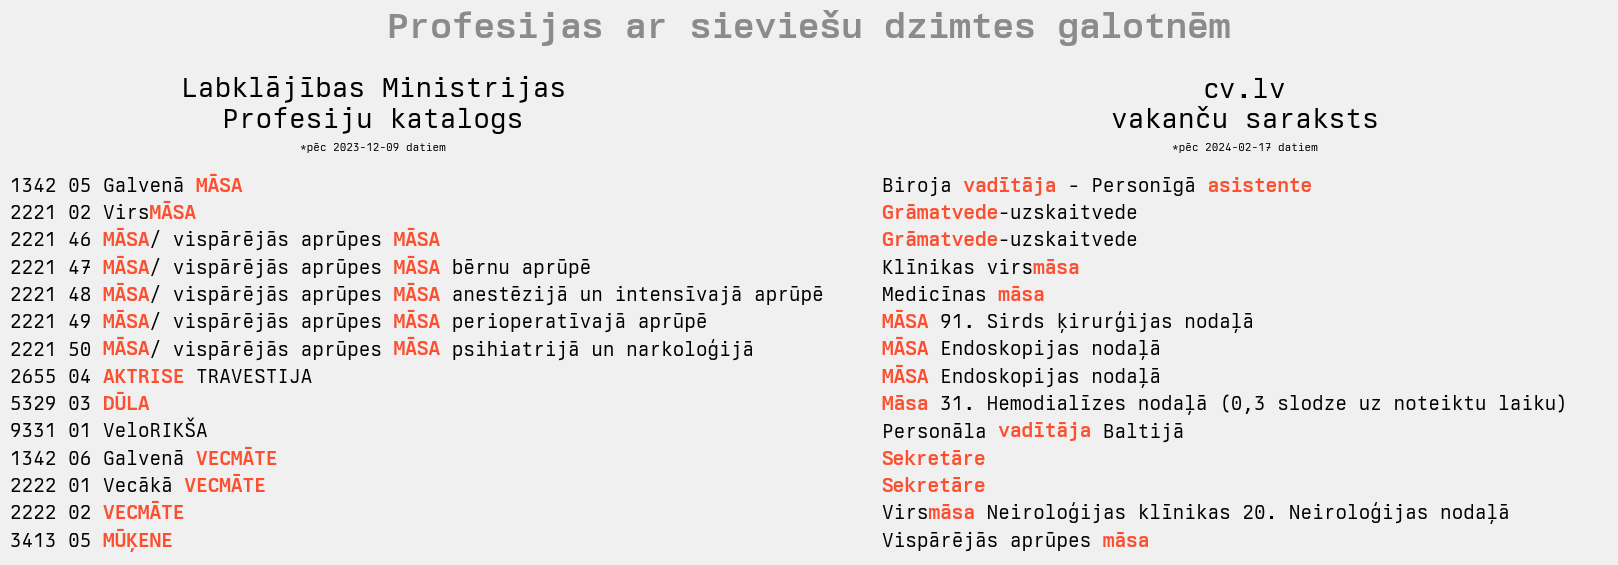

In [47]:
# Deklarē
fig,axes = plt.subplots(1,2,figsize=(17,6))
    
# Funkcija lai iekrāsotu sarkanus burtus
vardi = ['AKTRISE', 'asistente', 'DŪLA', 'Grāmatvede', 'MĀSA', 'Māsa', 'māsa', 'MŪĶENE', 'Sekretāre', 'vadītāja', 'VECMĀTE']
def burt_meln(s):
    s_return = ''
    current_w = ''
    for c in s:
        current_w += c
        if current_w in vardi:
            s_return += ' '*len(current_w)
            current_w = ''
        elif current_w[-4:] in vardi:
            s_return += current_w[:-4]+' '*4
            current_w = ''            
        elif c in [' ','-']:
            s_return += current_w
            current_w = ''               
    return s_return+current_w

def burt_sark(s):
    t = burt_meln(s)
    t_return = ''
    for c1,c2 in zip(s,t):
        if c1 == c2:
            t_return += ' '
        else:
            t_return += c1
    return t_return    

# Funckija lai uzzīmētu tekstu ar vienādu rindu atstarpi
def spacer(ax, s, topleft, lineheight, args_dict={}):
    for i,line in enumerate(s.split('\n')):
        x = topleft[0]
        y = topleft[1]-(i+.5)*lineheight
        ax.text(x, y, burt_meln(line), va='baseline', ha='left', transform=ax.transAxes, **args_dict)
        ax.text(x, y, burt_sark(line), va='baseline', ha='left', transform=ax.transAxes, c='C1', fontweight='bold', **args_dict)
    return ax
    
# Kreisā puse
ax = axes[0]
ax.set_title('Labklājības Ministrijas\nProfesiju katalogs')
ax.text(.5,.96,'*pēc 2023-12-09 datiem', ha='center', va='bottom', fontsize=8, transform=ax.transAxes)
text = '\n'.join(profesiju_dict['A']+profesiju_dict['E'])
spacer(ax, text, [0,.9], .065)

# Labā puse
ax = axes[1]
ax.set_title('cv.lv\nvakanču saraksts')
ax.text(.5,.96,'*pēc 2024-02-17 datiem', ha='center', va='bottom', fontsize=8, transform=ax.transAxes)
text = '\n'.join(np.sort(df2[~(df2['lv_s']==0)]['p']))
spacer(ax, text, [0,.9], .065)

# Stils
for ax in axes:
    ax.axis('off')

# Saglabā un parādi
plt.suptitle('Profesijas ar sieviešu dzimtes galotnēm', color='C4', fontsize=26, fontweight='bold',y=.96)
plt.subplots_adjust(top=.75, bottom=0.05, left=0.03, right=.97)
plt.savefig('new2.png', dpi=300)
plt.show()

In [74]:
for i in np.sort(df2[df2['lv_v']!=0]['p']):
    if 'grāmatvedis' in i.lower():
        print(i)

Galvenais Grāmatvedis
Galvenais grāmatvedis - finanšu direktors
Grāmatvedis
Grāmatvedis
Grāmatvedis
Grāmatvedis
Grāmatvedis
Jaunākais Kreditoru grāmatvedis
Jaunākais debitoru grāmatvedis
Tiesu administrācija Grāmatvedis (uz nenoteiktu laiku)


### Grafiks 4: algu nevienlīdzība

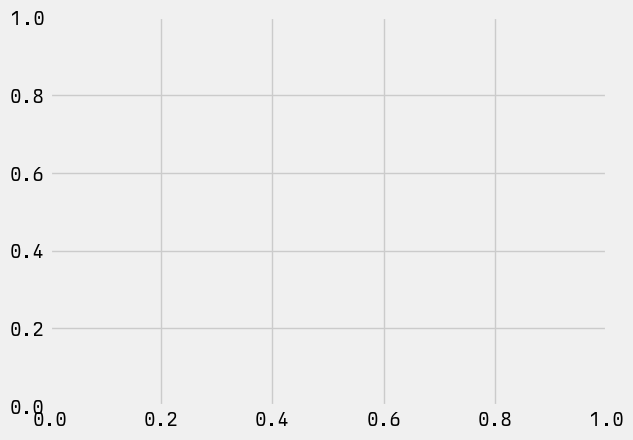

In [76]:
fig = plt.figure()
ax0 = plt.gca()

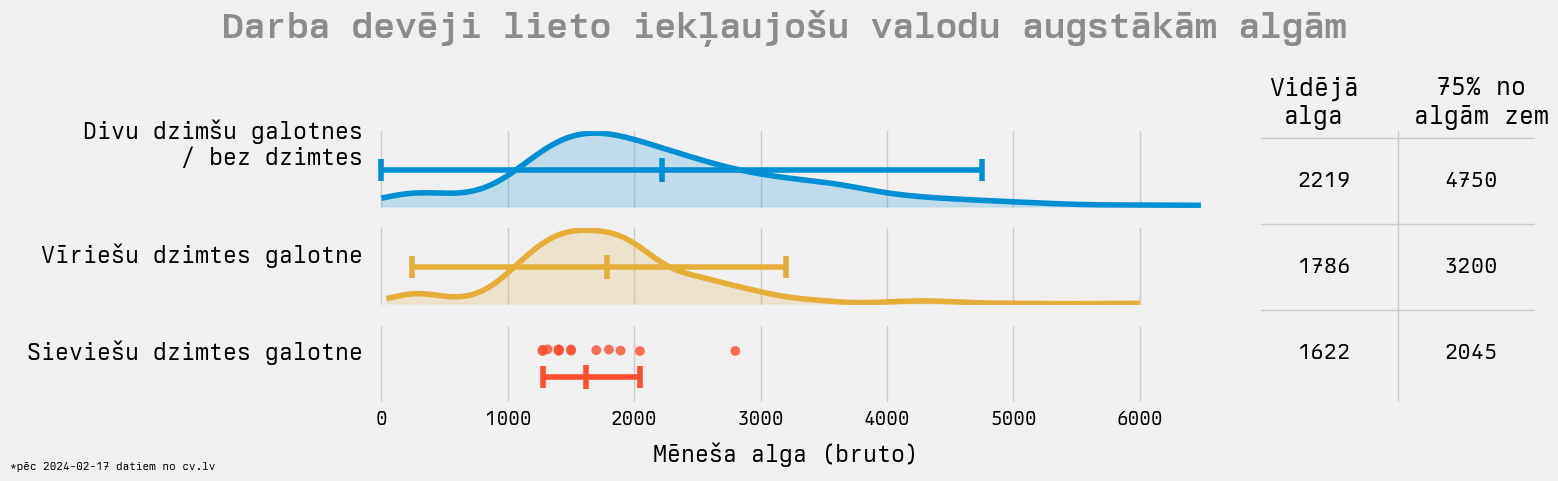

In [85]:
# Deklarē figūru
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[3,1],hspace=.1,wspace=.1)
gs_left = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0])
axes = [
    fig.add_subplot(gs_left[0]),
    fig.add_subplot(gs_left[1]),
    fig.add_subplot(gs_left[2])
]

# Stils
hist_opts = {'density':True, 'alpha':1}
box_opts = {'vert':False, 'showfliers':False, 'showbox':False}
text_opts = {'ha':'center', 'va':'center', 'fontsize':16}
cutoff = 7000

# Zīmē: tabula
ax_table = fig.add_subplot(gs[1])
ax_table.set_xlim([-1.9,1.9])
ax_table.set_ylim([-.6,2.6])
ax_table.set_xticks([0])
ax_table.set_xticklabels([])
ax_table.set_yticks([.5,1.5,2.5])
ax_table.set_yticklabels(['','',''])
ax_table.text(.2,1,'Vidējā\nalga',fontsize=18, ha='center', va='bottom', transform=ax_table.transAxes)
ax_table.text(.8,1,'75% no\nalgām zem',fontsize=18, ha='center', va='bottom', transform=ax_table.transAxes)

# Zīmē: lv
ax = axes[0]
data = df2[~(df2['lv']==0) | ~(df2['nonlv']==0) | ~(df2['mult']==0)]['alga'].values
data = [x for x in data if x <=cutoff]

density = gaussian_kde(data)
xs = np.linspace(max([0,min(data)]),min([max(data),cutoff]),200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs, density(xs), color='C0')
ax.fill_between(xs, np.zeros_like(xs), density(xs), color='C0', alpha=.2)

box = ax0.boxplot(data, **box_opts)
errs = [item.get_xdata()[1] for item in box['whiskers']]
ypos = max(density(xs))/2
ax.errorbar(np.mean(errs), ypos, yerr=None, xerr=(max(errs)-0)/2, capsize=8, capthick=4, c='C0')
ax.scatter(np.mean(data), ypos, marker='|', s=300)

ax.set_ylabel('Divu dzimšu galotnes\n/ bez dzimtes',rotation=0, ma='right', ha='right')
ax_table.text(-1,2,str(int(np.mean(data))), **text_opts)
ax_table.text(1,2,str(int(max(errs))), **text_opts)

# Zīmē: lv_v
ax = axes[1]
data = df2[~(df2['lv_v']==0)]['alga'].values
data = [x for x in data if x <=cutoff]

density = gaussian_kde(data)
xs = np.linspace(max([0,min(data)]),min([max(data),cutoff]),200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax.plot(xs, density(xs), color='C2')
ax.fill_between(xs, np.zeros_like(xs), density(xs), color='C2', alpha=.2)

box = ax0.boxplot(data, **box_opts)
errs = [item.get_xdata()[1] for item in box['whiskers']]
ypos = max(density(xs))/2
ax.errorbar(np.mean(errs), ypos, yerr=None, xerr=(max(errs)-min(errs))/2, capsize=8, capthick=4, c='C2')
ax.scatter(np.mean(data), ypos, marker='|', s=300, c='C2')

ax.set_ylabel('Vīriešu dzimtes galotne',rotation=0, ma='right', ha='right')
ax_table.text(-1,1,str(int(np.mean(data))), **text_opts)
ax_table.text(1,1,str(int(max(errs))), **text_opts)

# Zīmē: lv_s
ax = axes[2]
data = df2[~(df2['lv_s']==0)]['alga'].values

ax.scatter(data, [.95+np.random.rand()*.1 for _ in range(len(data))], color='C1',s=50, alpha=.8, ec=None)
ax.set_ylim([-1,2])

box = ax0.boxplot(data, boxprops={'color':'C1'}, **box_opts)
errs = [item.get_xdata()[1] for item in box['whiskers']]
# errs = np.sort(data)[np.array([0,-2])]
ypos = 0
data = [x-10+np.random.rand()*20 for x in data]
ax.errorbar(np.mean(errs), ypos, yerr=None, xerr=(max(errs)-min(errs))/2, capsize=8, capthick=4, c='C1')
ax.scatter(np.mean(data), ypos, marker='|', s=300, c='C1')

ax.set_ylabel('Sieviešu dzimtes galotne',rotation=0, ma='right', ha='right')
ax_table.text(-1,0,str(int(np.mean(data))), **text_opts)
ax_table.text(1,0,str(int(max(errs))), **text_opts)


# Stils
xmin,xmax = (min(df2['alga'].values),max(df2['alga'].values))
for i,ax in enumerate(axes):
    if i < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Mēneša alga (bruto)', labelpad=10)
    ax.set_xlim([-100,6500])
    ax.set_yticks([])
ax.text(-.43,-.7,'*pēc 2024-02-17 datiem no cv.lv', ha='left', va='top', fontsize=8, transform=ax.transAxes)


# Parādi
plt.suptitle('Darba devēji lieto iekļaujošu valodu augstākām algām', color='C4', fontsize=26, fontweight='bold',y=.96)
plt.subplots_adjust(top=.72, bottom=.17, left=.24, right=.97)
plt.savefig('new3.png', dpi=300)
plt.show()